# Springboard - Data Science Career Track

## Data Analysis Interview Challenge

## Project: Take-Home Challenge - Ultimate Technologies Inc.

**Table of contents:**

[Part 1 - Exploratory Data Analysis](#eda)

[Part 2 - Experiment and metrics design](#experiment_metrics_design)

[Part 3 - Predictive modeling](#modeling)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import json
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb


## Part 1 - Exploratory Data Analysis
<a id="eda"></a>

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location.  
Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
# load as pandas dataframe
logins_df = pd.read_json('logins.json')

# info
print(logins_df.info())

# head
logins_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# missing values
logins_df.login_time.isna().value_counts()

False    93142
Name: login_time, dtype: int64

In [4]:
# sort by date/time
logins_df = logins_df.sort_values('login_time').reset_index(drop=True)
logins_df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [5]:
# tail
logins_df.tail()

,login_time
93137,1970-04-13 18:48:52
93138,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93140,1970-04-13 18:54:23
93141,1970-04-13 18:57:38


<div class="span5 alert alert-info">
Aggregate these login counts based on 15minute time intervals
</div>

In [6]:
# set index
logins_df.set_index('login_time', inplace=True)

# count column for logins
logins_df['count_logins'] = 1 

In [7]:
logins_df.head(10)

,count_logins
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1
1970-01-01 20:21:41,1
1970-01-01 20:26:05,1
1970-01-01 20:26:21,1
1970-01-01 20:31:03,1


In [8]:
# login counts based on 15 minute time intervals
logins_df = logins_df.resample('15T').sum()
logins_df.head()

,count_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


<div class="span5 alert alert-info">
Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.
 </div>

In [9]:
print("The data goes from  {}  till  {} ".format(logins_df.index[0], logins_df.index[-1]))

The data goes from  1970-01-01 20:00:00  till  1970-04-13 18:45:00 


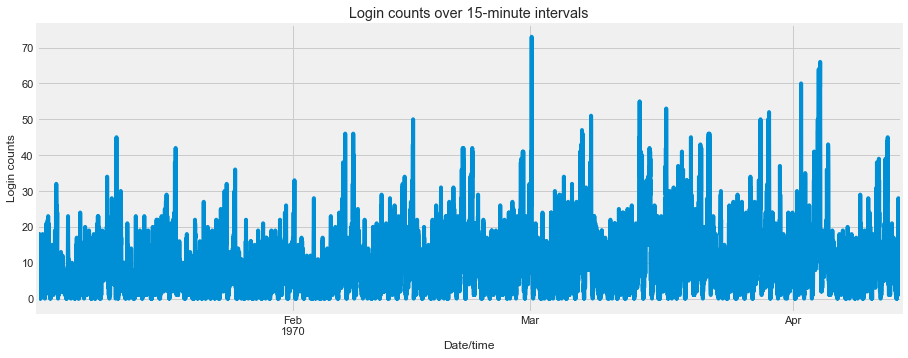

In [10]:
# login times over time
logins_df.plot(legend=False)
plt.title('Login counts over 15-minute intervals')
plt.xlabel('Date/time')
plt.ylabel('Login counts')
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

There is definitely a cyclical nature associated with these logins. We can also notice some bursts of sudden activity, specially the one in beginning of March, where it reached more than 70 logins in a 15-minute interval.

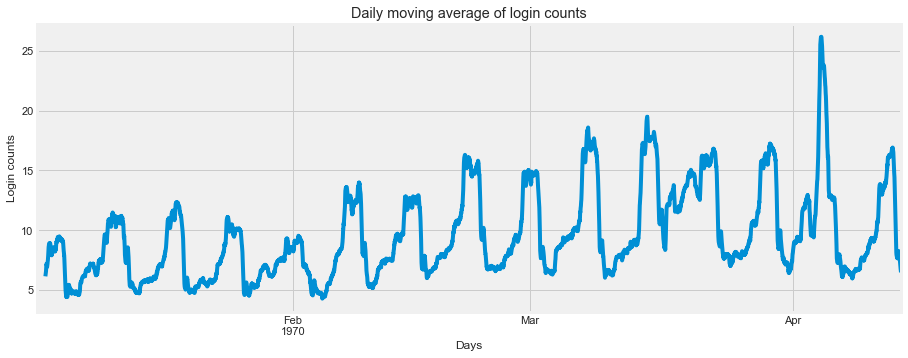

In [11]:
# daily moving average
logins_df.rolling(window=4*24).mean().plot(legend=False)
plt.title('Daily moving average of login counts')
plt.xlabel('Days')
plt.ylabel('Login counts')
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

When analyzing the daily moving average, we see an upward tendency from January till April. The cyclical nature is even more evident now, where there is a clear pattern of some days where there are no average-15-minute login attempts and periodical increases until about 15-20.

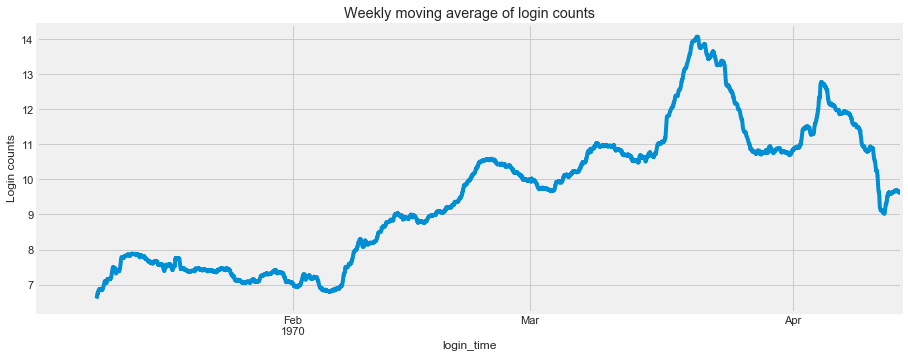

In [12]:
# weekly moving average
logins_df.rolling(window=4*24*7).mean().plot(legend=False)
plt.title('Weekly moving average of login counts')
plt.ylabel('Login counts')
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

When plotting the weekly moving average, we notice a clear upward tendency until about middle of March, to then decrease a bit until middle April.

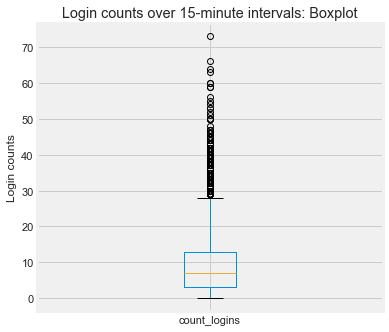

In [13]:
# boxplot
logins_df.boxplot()
plt.title('Login counts over 15-minute intervals: Boxplot')
plt.ylabel('Login counts')
plt.subplots_adjust(left=0, bottom=0, right=0.8, top=1, wspace=0, hspace=0)
plt.show()

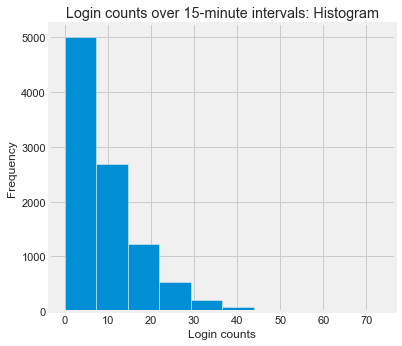

In [14]:
# histogram
logins_df.plot(kind='hist', legend=False)
plt.title('Login counts over 15-minute intervals: Histogram')
plt.xlabel("Login counts")
plt.subplots_adjust(left=0, bottom=0, right=0.8, top=1, wspace=0, hspace=0)
plt.show()

Over 30 logins it starts to look as outliers, but as seen before, it is noticeable the increasing tendency. With maybe the exception, as noticed, of the middle of the interval range point in the beginning of March.

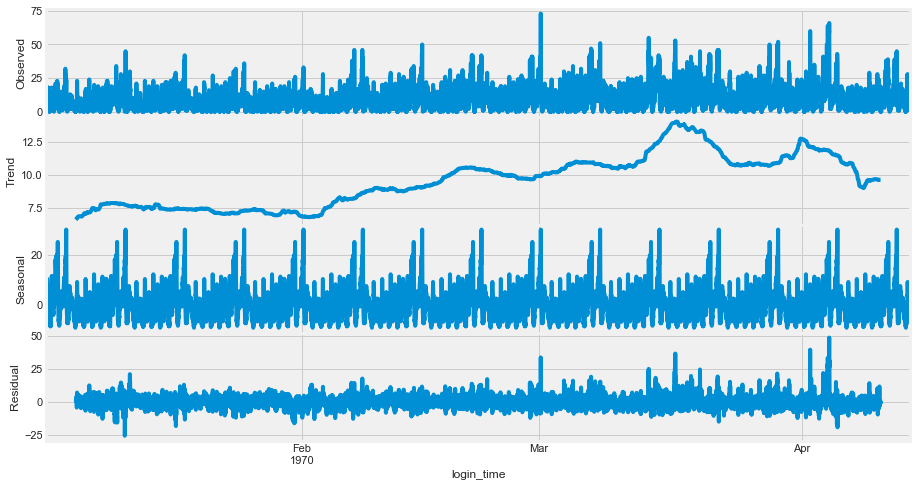

In [15]:
# time series decomposition
import statsmodels.api as sm

# decomposition - weekly
decomposition = sm.tsa.seasonal_decompose(logins_df, model='additive', freq=4*24*7)  
decomposition.plot()

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

The seasonality, trend and noise components seen above summarize the described behavior of login counts.

## Part 2 - Experiment and metrics design
<a id="experiment_metrics_design"></a>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

**1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

The difference between the fraction of people who traversed the bridge. I would choose this metric since it can show reasonably well if there is actually a significant improvement. 

**2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.**

Please provide details on:
 - how you will implement the experiment
 - what statistical test(s) you will conduct to verify the significance of the observation
 - how you would interpret the results and provide recommendations to the city operations team along with any caveats.


I would perform A/B testing. The difference between the fraction of the population that crosses the toll bridge, as mentioned before, would serve as the test statistic. We would randomly take 50% of the population and reimburse them all toll costs, while for the other 50% of the population no reimburse would be made, as it currently is. Then, we would compute the difference between the fraction of people (test statistic) of both groups. The test statistic could be computed as follows:

In [16]:
def diff_frac(data_A, data_B):
    frac_pop_A = np.sum(data_A) / len(data_A)  # population without reimbursement
    frac_pop_B = np.sum(data_B) / len(data_B)  # population with reimbursement
    return frac_B - frac_A

The observed difference would then be computed. We would verify the significance of the observed difference by first generating a sufficiently large number of permutation samples of the fraction differences, using the following functions: 

In [17]:
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)

    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

Then, we would compute the p-value, or the percentage of replications that would be equal or greater than the observed difference. If, for instance, we define a significance level of 5%, if we find a p-value with a smaller value it would mean that the experiment would be successful. We could then say that we had sufficient statistical evidence to conclude that the difference between the fraction of the population that benefited from the reimbursement and the population that did not would be significant, which could encourage the Ultimate managers to go ahead with the reimbursement experience.

Note that statistical significance is not the same as what could be called practical significance. Also, a p-value of 0.049 is different than 0.00001, and it should always be considered many other variables, like actually how many people are in both cities and if the costs would compensate that.

## Part 3 - Predictive modeling
<a id="modeling"></a>

Ultimate is interested in **predicting rider retention**. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

**Data description:**

- **city**: city this user signed up in
- **phone**: primary device for this user
- **signup_date**: date of account registration; in the form ‘YYYY MM DD’
- **last_trip_date**: the last time this user completed a trip; in the form ‘YYYY MM DD’
- **avg_dist**: the average distance in miles per trip taken in the first 30 days after signup
- **avg_rating_by_driver**: the rider’s average rating over all of their trips
- **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips
- **surge_pct**: the percent of trips taken with surge multiplier > 1
- **avg_surge**: The average surge multiplier over all of this user’s trips
- **trips_in_first_30_days**: the number of trips this user took in the first 30 days after signing up
- **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- **weekday_pct**: the percent of the user’s trips occurring during a weekday

<div class="span5 alert alert-info">
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
</div>

In [18]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
ultimate_df = pd.DataFrame(data)

In [19]:
# info
print(ultimate_df.info())

# head
ultimate_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


#### Cleaning

In [20]:
# convert to datetime the following columns
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

In [21]:
# missing data - I will replace the missing ratings by the average values
ultimate_df['avg_rating_by_driver'].fillna(round(np.mean(ultimate_df['avg_rating_by_driver']), 1), inplace=True)
ultimate_df['avg_rating_of_driver'].fillna(round(np.mean(ultimate_df['avg_rating_of_driver']), 1), inplace=True)

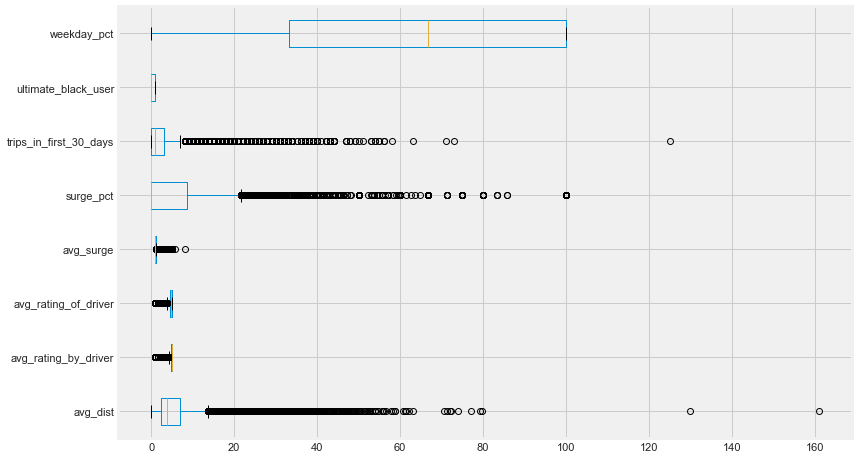

In [22]:
# check for outliers
ultimate_df.boxplot(vert=False)

plt.subplots_adjust(left=0, bottom=-0.5, right=1.7, top=1, wspace=0, hspace=0)
plt.show()

I will accept these values for now.

#### Exploratory Analysis

In [23]:
# describe
ultimate_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778246,4.601306,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.445755,0.564977,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [24]:
# user retained if they took a trip 30 days before the moment this data was gathered (I'll assume as last 'last_trip_date')
max_time = (ultimate_df['last_trip_date'].max() - timedelta(30))

print("The limit date for retain classification consideration is {}".format(max_time))

# create column "retained"
ultimate_df['retained'] = ultimate_df['last_trip_date'] >= max_time

ultimate_df.head()

The limit date for retain classification consideration is 2014-06-01 00:00:00


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


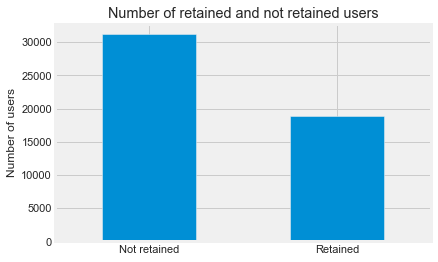

In [25]:
# barplot
ultimate_df['retained'].value_counts().plot(kind='bar')
plt.title('Number of retained and not retained users')
plt.xticks([0, 1], ['Not retained', 'Retained'], rotation=0)
plt.ylabel('Number of users')
plt.show()

In [26]:
# percentage of people retained
ultimate_df['retained'].value_counts()/len(ultimate_df)

False    0.62392
True     0.37608
Name: retained, dtype: float64

**Approximately 38% of the users were considered to be retained.**

In [27]:
# correlations with target
ultimate_df.corr(method='pearson')['retained'].sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.010667
avg_rating_by_driver     -0.026828
avg_dist                 -0.092780
Name: retained, dtype: float64

The number of trips and taking an ultimate black during the first 30 days seem to be the most correlated variables with retainment. 

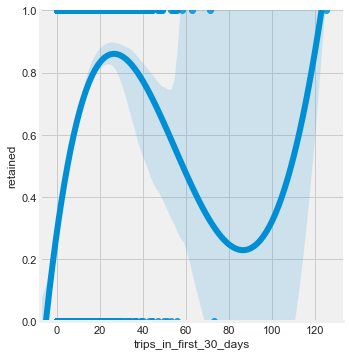

In [28]:
# relationship with trips_in_first_30_days
sns.lmplot(data=ultimate_df, x='trips_in_first_30_days', y='retained', order=4)
plt.ylim(0, 1)
plt.show()

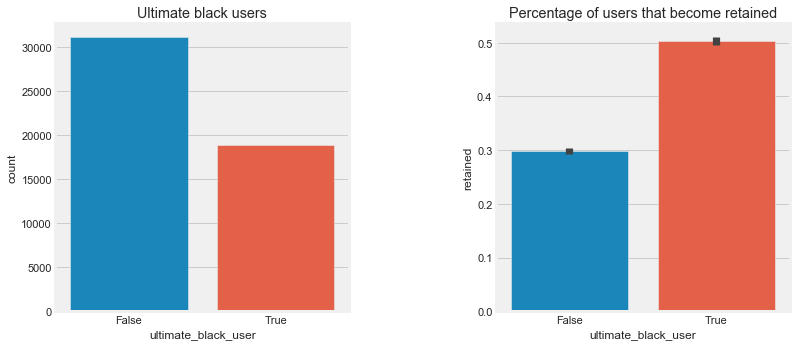

In [29]:
# ultimate black users
plt.subplot(1, 2, 1)
sns.countplot(ultimate_df.ultimate_black_user)
plt.title('Ultimate black users')

plt.subplot(1, 2, 2)
sns.barplot(x="ultimate_black_user", y="retained", data=ultimate_df)
plt.title('Percentage of users that become retained')

plt.subplots_adjust(left=0, bottom=0, right=1.7, top=1, wspace=0.5, hspace=0)
plt.show()

Categorical variables

In [30]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.3+ MB


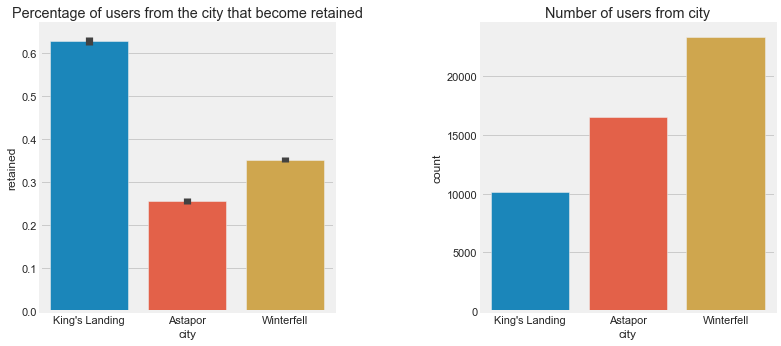

In [31]:
# Percentage of city users that become retained
plt.subplot(1, 2, 1)
sns.barplot(x="city", y="retained", data=ultimate_df)
plt.title('Percentage of users from the city that become retained')

# countplot cities
plt.subplot(1, 2, 2)
sns.countplot(ultimate_df.city)
plt.title('Number of users from city')

plt.subplots_adjust(left=0, bottom=0, right=1.7, top=1, wspace=0.5, hspace=0)
plt.show()

In [32]:
ultimate_df[ultimate_df.retained == True].city.value_counts()

Winterfell        8213
King's Landing    6363
Astapor           4228
Name: city, dtype: int64

We see that King's Landing has strong retention (more than 60%), although less users, when comparing to other cities, but still Winterfell is the city which retains more people in absolute terms.

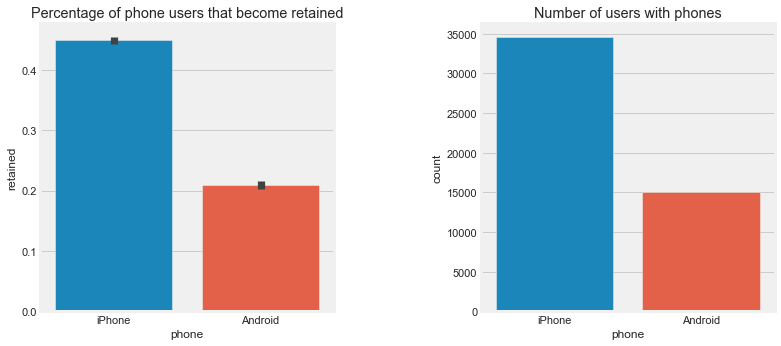

In [33]:
# Percentage of phone users that become retained
plt.subplot(1, 2, 1)
sns.barplot(x="phone", y="retained", data=ultimate_df)
plt.title('Percentage of phone users that become retained')

# countplot phones
plt.subplot(1, 2, 2)
sns.countplot(ultimate_df.phone)
plt.title('Number of users with phones')

plt.subplots_adjust(left=0, bottom=0, right=1.7, top=1, wspace=0.5, hspace=0)
plt.show()

In [34]:
# absolute values
ultimate_df[ultimate_df.retained == True].phone.value_counts()

iPhone     15525
Android     3146
Name: phone, dtype: int64

Iphone users seem more predisposed to become retained for some reason.

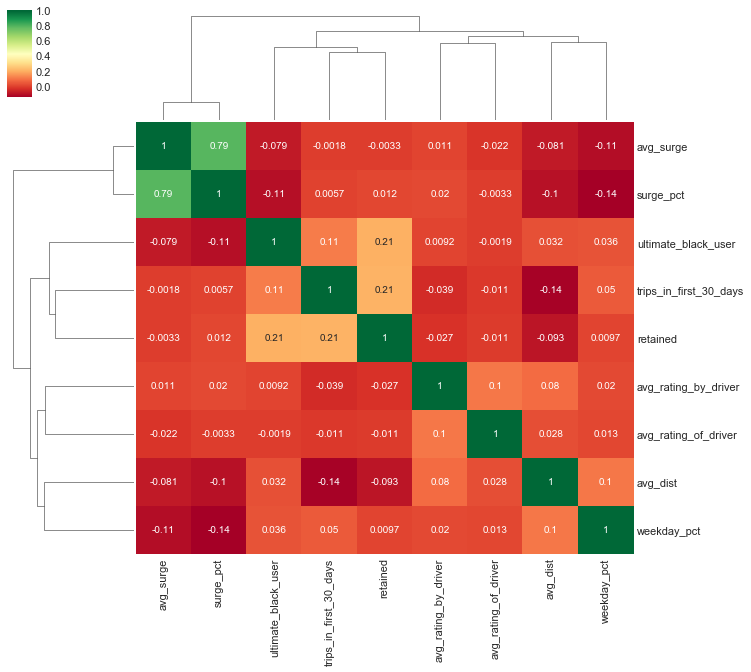

In [35]:
# correlation between variables
sns.clustermap(ultimate_df.corr(method='pearson'),cmap='RdYlGn', annot=True)
plt.show()

<div class="span5 alert alert-info">
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
</div>

Since we are dealing with unbalanced data as we saw in the very beginning, I will test algorithms that can adapt to that. For linear models we might want to consider either 'avg_surge' or 'surge_pct', due to their high correlation --> this would cause interpretability problems. For the categorical variables, I will create dummy variables. I will also exclude the variable related with the last trip date since it is not relevant to the problem.

In [36]:
# set index
ultimate_df.set_index('signup_date', inplace=True)
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
signup_date,,,,,,,,,,,,
2014-01-25,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,15.4,4,True,46.2,True
2014-01-29,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,0.0,0,False,50.0,False
2014-01-06,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,0.0,3,False,100.0,False
2014-01-10,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,20.0,9,True,80.0,True
2014-01-27,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,11.8,14,False,82.4,False


In [37]:
# transform the data to operate with and split into train and test data

# target
y = ultimate_df['retained']

# exclude surge_pct and last_trip_date, get dummy variables and normalize
X = ultimate_df.drop(['surge_pct', 'last_trip_date', 'retained'], axis=1)
X = pd.get_dummies(X)
X = scale(X)


# Split into train (70%) and test (30%) sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [38]:
# set seed for reproducibility
SEED = 1

#### Logistic Regression

In [39]:
%%time
from sklearn.linear_model import LogisticRegression

# instantiate the model
clf_logreg = LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='auto', random_state=SEED)

# train the model
clf_logreg.fit(X_train, y_train)

Wall time: 84 ms


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
model = clf_logreg
model_name = 'LogisticRegression'

In [41]:
# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6966

Confusion matrix:
 [[4481 1758]
 [1276 2485]]

Classification report:
               precision    recall  f1-score   support

       False       0.78      0.72      0.75      6239
        True       0.59      0.66      0.62      3761

    accuracy                           0.70     10000
   macro avg       0.68      0.69      0.68     10000
weighted avg       0.71      0.70      0.70     10000


AUC: 0.7531031376722634


#### RandomForestClassifier

In [42]:
%%time
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
clf_rf = RandomForestClassifier(random_state=SEED, class_weight='balanced', n_estimators=10)

# train the model
clf_rf.fit(X_train, y_train)

Wall time: 443 ms


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [43]:
model = clf_rf
model_name = 'RandomForestClassifier'

In [44]:
# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.7467

Confusion matrix:
 [[5219 1020]
 [1513 2248]]

Classification report:
               precision    recall  f1-score   support

       False       0.78      0.84      0.80      6239
        True       0.69      0.60      0.64      3761

    accuracy                           0.75     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.74      0.75      0.74     10000


AUC: 0.8021325189872063


#### AdaBoostClassifier w/ Logistic Regression

In [45]:
%%time
from sklearn.ensemble import AdaBoostClassifier

# instantiate the model
clf_ada = AdaBoostClassifier(base_estimator=clf_logreg, random_state=SEED)

# train the model
clf_ada.fit(X_train, y_train)

Wall time: 1.9 s


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=1,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=1.0

In [46]:
model = clf_ada
model_name = 'AdaBoostClassifier'

In [47]:
# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6933

Confusion matrix:
 [[4436 1803]
 [1264 2497]]

Classification report:
               precision    recall  f1-score   support

       False       0.78      0.71      0.74      6239
        True       0.58      0.66      0.62      3761

    accuracy                           0.69     10000
   macro avg       0.68      0.69      0.68     10000
weighted avg       0.70      0.69      0.70     10000


AUC: 0.7514935406229881


#### Extreme Gradient Boosting (XGBoost)

In [48]:
%%time
import xgboost as xgb

# instantiate the model
clf_xgb = xgb.XGBClassifier(random_state=SEED, n_estimators=10)

# train the model
clf_xgb.fit(X_train, y_train)

Wall time: 397 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [49]:
model = clf_xgb
model_name = 'XGBClassifier'

In [50]:
# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.7706

Confusion matrix:
 [[5266  973]
 [1321 2440]]

Classification report:
               precision    recall  f1-score   support

       False       0.80      0.84      0.82      6239
        True       0.71      0.65      0.68      3761

    accuracy                           0.77     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.77      0.77      0.77     10000


AUC: 0.832602759213035


#### Model comparison

The XGBClassifier provided the best general results, with 77% accuracy and an AUC score of 0.83, which is good. I also considered this model since it can provide feature importances, or which variables were most relevant to explain the user's retainment. The RandomForestClassifier also got close results.

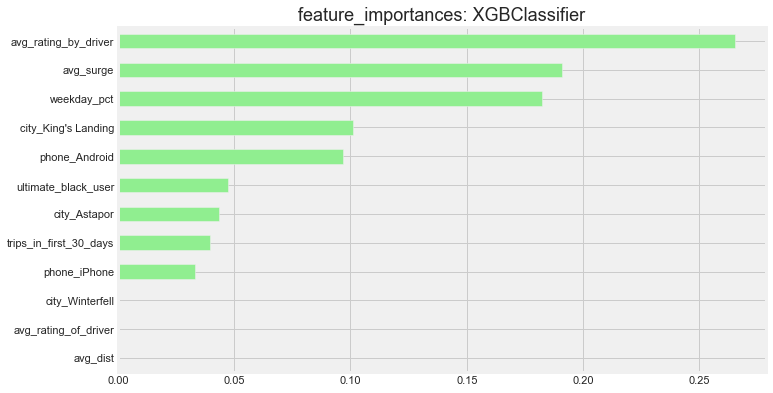

In [51]:
# X columns
X_columns = pd.get_dummies(ultimate_df.drop(['surge_pct', 'last_trip_date', 'retained'], axis=1)).columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=clf_xgb.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('feature_importances: {}'.format('XGBClassifier'), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

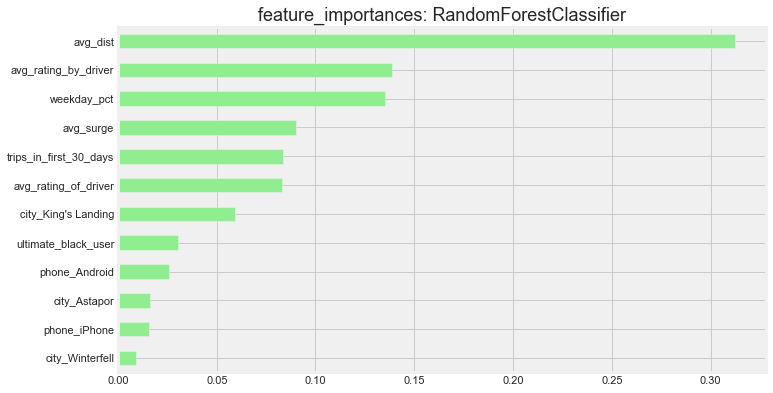

In [52]:
# X columns
X_columns = pd.get_dummies(ultimate_df.drop(['surge_pct', 'last_trip_date', 'retained'], axis=1)).columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=clf_rf.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('feature_importances: {}'.format('RandomForestClassifier'), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

We could still improve the results if we made feature selection and hyperparameter tuning, for example.

<div class="span5 alert alert-info">
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).
</div>

According to the best algorithms we tested in order to predict user retention, and combining with the previous EDA analysis made, we can identify some features which are relevant to take into consideration if Ultimate pretends to improve their retention success:

- Average rating by driver: explicit behavior important for retention, although surprisingly negatively correlated (not much).
- The average surge multiplier or, equivalently, the percent of trips taken with surge multiplier > 1: the smaller the better, or otherwise it could scare users.
- The percent of the user's trips occurring during a weekday: most retentions were focused here.
- Take notice of users from the cities of Astapor and Winterfell: they are not getting as good retention when compared with King's Landing users, at least.
- Android users do not get very effective retention for some reason.
- The average distance in miles per trip taken in the first 30 days after signup: focus on higher values, as a negative sign.

Also, consider the number of trips and taking an ultimate black during the first 30 days as well, as positive and impactful correlations with retention.
